# Лабораторная работа 4: Деревья. Случайный лес

## Часть 1: Основы построения решающие дерева

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [ ]:
# Количество объектов каждого класса
n_k1 = 8
n_k2 = 2
total = n_k1 + n_k2

# Расчет вероятностей
p_k1 = n_k1 / total
p_k2 = n_k2 / total

# Вычисляем энтропию
entropy = - (p_k1 * np.log(p_k1) + p_k2 * np.log(p_k2))

# Округляем до двух знаков
entropy_rounded = round(entropy, 2)

print(entropy_rounded)

0.5


**Задание 1.2** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [ ]:
# Общее число объектов в вершине
N_total = 10
n_k1 = 8
n_k2 = 2

# Вероятности классов
p_k1 = n_k1 / N_total
p_k2 = n_k2 / N_total

# Индекс Джини для всей вершины
H_Rm = p_k1 * (1 - p_k1) + p_k2 * (1 - p_k2)

# Множества объектов после разбиения
# В левое поддерево попадают все объекты класса k1
N_left = n_k1
# В правое — все объекты класса k2
N_right = n_k2

# Вероятности для поддеревьев
p_left_k1 = 1.0  # все к1
p_left_k2 = 0.0

p_right_k1 = 0.0
p_right_k2 = 1.0

# Размеры поддеревьев
N_left_total = N_left
N_right_total = N_right

# Индекс Джини для левого поддерева
H_Rl = p_left_k1 * (1 - p_left_k1) + p_left_k2 * (1 - p_left_k2)
# Индекс Джини для правого поддерева
H_Rr = p_right_k1 * (1 - p_right_k1) + p_right_k2 * (1 - p_right_k2)

# Вычисляем критерий информативности
Q = H_Rm - (N_left_total / N_total) * H_Rl - (N_right_total / N_total) * H_Rr

# Округляем до двух знаков
Q_rounded = round(Q, 2)

print(Q_rounded)

0.32


**Задание 1.3** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [ ]:
# Значения целевой переменной для объектов в листе
target_values = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])

# Расчет среднего значения
prediction = np.mean(target_values)

print(prediction)

40.6


## Часть 2: Решающие деревья

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-

    pass

In [ ]:


def find_best_split(
    feature_vector: Union[np.ndarray, pd.Series],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    # Приведение к numpy массивам для удобства
    X = np.array(feature_vector)
    y = np.array(target_vector)
    n_samples = len(X)

    # Проверка на плотность данных
    if n_samples == 0:
        return np.array([]), np.array([]), 0, 0

    # Определяем функцию подсчета критерия
    def calculate_variance(targets):
        return np.var(targets)  # дисперсия для регрессии

    def calculate_gini(targets):
        # Индекс Джини для задачи классификации
        classes, counts = np.unique(targets, return_counts=True)
        probs = counts / counts.sum()
        return np.sum(probs * (1 - probs))

    # Вектор хранения порогов, критериев
    thresholds = []
    ginis = []

    # Обработка категориальных признаков
    if feature_type == 'categorical':
        unique_values = np.unique(X)
        # Для каждого уникального значения — разделение
        for val in unique_values:
            mask_left = (X == val)
            mask_right = (X != val)
            targets_left = y[mask_left]
            targets_right = y[mask_right]
            if len(targets_left) == 0 or len(targets_right) == 0:
                continue  # пропуск, если разбиение пустое

            if task == "classification":
                gini_left = calculate_gini(targets_left)
                gini_right = calculate_gini(targets_right)
                gini_split = gini_left * len(targets_left) / n_samples + gini_right * len(targets_right) / n_samples
                # Чем меньше gini, тем лучше, поэтому для поиска максимума ищем минимальный gini
                # Но по условию, ищем максимальный прирост, проще: считаем его как снижение gini
                # В данном случае можно взять -gini, чтобы искать максимум
                ginis.append(-gini_split)
            else:
                # регрессия: дисперсия внутри подвыборок
                var_left = calculate_variance(targets_left)
                var_right = calculate_variance(targets_right)
                weighted_var = var_left * len(targets_left) / n_samples + var_right * len(targets_right) / n_samples
                ginis.append(-weighted_var)  # для поиска максимума
            thresholds.append(val)
        # Возвращаем массивы
        return np.array(thresholds), np.array(ginis), None, None

    # Обработка вещественных признаков
    elif feature_type == 'real':
        # сортируем объекты по признаку
        sorted_idx = np.argsort(X)
        X_sorted = X[sorted_idx]
        y_sorted = y[sorted_idx]

        # Возможные пороги - средние значения между соседними уникальными значениями
        unique_values = np.unique(X_sorted)
        if len(unique_values) == 1:
            # Если все одинаковы, разбиение невозможно
            return np.array([]), np.array([]), float('nan'), float('nan')

        # Находим все границы между соседними уникальными значениями
        potential_thresholds = (unique_values[:-1] + unique_values[1:]) / 2

        # Для каждого порога, разбиваем выборку
        for thr in potential_thresholds:
            mask_left = (X_sorted <= thr)
            mask_right = (X_sorted > thr)
            targets_left = y_sorted[mask_left]
            targets_right = y_sorted[mask_right]
            if len(targets_left) == 0 or len(targets_right) == 0:
                continue  # пропуск, если разбиение пустое

            if task == "classification":
                gini_left = calculate_gini(targets_left)
                gini_right = calculate_gini(targets_right)
                gini_split = gini_left * len(targets_left) / n_samples + gini_right * len(targets_right) / n_samples
                ginis.append(-gini_split)
            else:
                var_left = calculate_variance(targets_left)
                var_right = calculate_variance(targets_right)
                weighted_var = var_left * len(targets_left) / n_samples + var_right * len(targets_right) / n_samples
                ginis.append(-weighted_var)
            thresholds.append(thr)

        return np.array(thresholds), np.array(ginis), None, None

    else:
        raise ValueError("Unknown feature_type. Should be 'real' or 'categorical'.")

Эту функцию можно протестировать на датасете `California`.

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

def find_best_split(
    feature_vector: Union[np.ndarray, pd.Series],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "regression",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Находит оптимальное разбиение для подмножества данных

    Parameters:
    feature_vector: признаки
    target_vector: целевая переменная
    task: "regression" или "classification"
    feature_type: "real" или "categorical"

    Returns:
    thresholds: массив порогов
    criteria: массив значений критерия (чем больше, тем лучше)
    best_threshold: лучший порог
    best_criterion: лучшее значение критерия
    """
    X = np.array(feature_vector)
    y = np.array(target_vector)
    n_samples = len(X)

    if n_samples < 2:
        return np.array([]), np.array([]), float('nan'), float('nan')

    def calculate_criterion(targets):
        if task == "regression":
            return np.var(targets)  # дисперсия для регрессии
        else:
            # Индекс Джини для классификации
            if len(targets) == 0:
                return 0
            classes, counts = np.unique(targets, return_counts=True)
            probs = counts / len(targets)
            return 1 - np.sum(probs ** 2)  # Gini impurity

    # Критерий для родительского узла
    parent_criterion = calculate_criterion(y)

    thresholds = []
    gains = []  # Будем хранить выигрыш (gain), а не взвешенный критерий

    if feature_type == 'real':
        # Сортируем по признаку
        sorted_indices = np.argsort(X)
        X_sorted = X[sorted_indices]
        y_sorted = y[sorted_indices]

        # Уникальные значения признака
        unique_X = np.unique(X_sorted)
        if len(unique_X) == 1:
            return np.array([]), np.array([]), float('nan'), float('nan')

        # Потенциальные пороги - середины между соседними уникальными значениями
        potential_thresholds = (unique_X[:-1] + unique_X[1:]) / 2

        for threshold in potential_thresholds:
            left_mask = X_sorted <= threshold
            right_mask = X_sorted > threshold

            y_left = y_sorted[left_mask]
            y_right = y_sorted[right_mask]

            if len(y_left) == 0 or len(y_right) == 0:
                continue

            # Взвешенный критерий для дочерних узлов
            left_criterion = calculate_criterion(y_left)
            right_criterion = calculate_criterion(y_right)
            weighted_criterion = (len(y_left) * left_criterion + len(y_right) * right_criterion) / n_samples

            # Информационный выигрыш
            gain = parent_criterion - weighted_criterion
            gains.append(gain)
            thresholds.append(threshold)

    elif feature_type == 'categorical':
        unique_values = np.unique(X)

        for value in unique_values:
            left_mask = X == value
            right_mask = X != value

            y_left = y[left_mask]
            y_right = y[right_mask]

            if len(y_left) == 0 or len(y_right) == 0:
                continue

            left_criterion = calculate_criterion(y_left)
            right_criterion = calculate_criterion(y_right)
            weighted_criterion = (len(y_left) * left_criterion + len(y_right) * right_criterion) / n_samples

            gain = parent_criterion - weighted_criterion
            gains.append(gain)
            thresholds.append(value)

    else:
        raise ValueError("feature_type должен быть 'real' или 'categorical'")

    if len(gains) == 0:
        return np.array([]), np.array([]), float('nan'), float('nan')

    # Находим лучший порог
    best_idx = np.argmax(gains)
    best_threshold = thresholds[best_idx]
    best_gain = gains[best_idx]

    return np.array(thresholds), np.array(gains), best_threshold, best_gain

# Загружаем данные
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]

print("Первые 5 строк данных:")
print(X.head())
print("\nЦелевая переменная (первые 10 значений):")
print(y[:10])

Первые 5 строк данных:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  

Целевая переменная (первые 10 значений):
[4.526 3.585 3.521 3.413 3.422 2.697 2.992 2.414 2.267 2.611]


Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

Лучший порог для MedInc: 5.0351
Лучший выигрыш: 0.412751


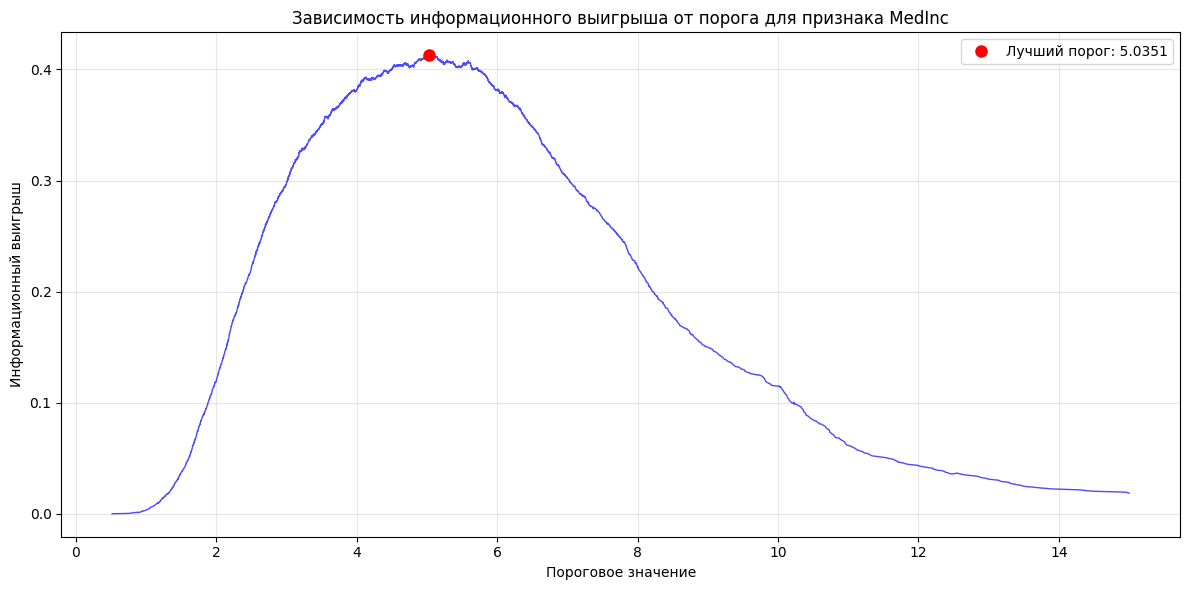


Статистика лучшего разбиения:
Объектов слева: 16255
Объектов справа: 4385
Среднее значение слева: 1.7349
Среднее значение справа: 3.3055
Дисперсия слева: 0.8374
Дисперсия справа: 1.2207


In [ ]:
# График для признака MedInc
feature_name = "MedInc"
feature_values = X[feature_name].values

# Находим все возможные разбиения
thresholds, gains, best_threshold, best_gain = find_best_split(
    feature_vector=feature_values,
    target_vector=y,
    task="regression",
    feature_type="real"
)

print(f"Лучший порог для {feature_name}: {best_threshold:.4f}")
print(f"Лучший выигрыш: {best_gain:.6f}")

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(thresholds, gains, 'b-', alpha=0.7, linewidth=1)
plt.plot(best_threshold, best_gain, 'ro', markersize=8, label=f'Лучший порог: {best_threshold:.4f}')
plt.xlabel('Пороговое значение')
plt.ylabel('Информационный выигрыш')
plt.title(f'Зависимость информационного выигрыша от порога для признака {feature_name}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Выводим статистику по лучшему разбиению
if not np.isnan(best_threshold):
    left_mask = feature_values <= best_threshold
    right_mask = feature_values > best_threshold

    y_left = y[left_mask]
    y_right = y[right_mask]

    print(f"\nСтатистика лучшего разбиения:")
    print(f"Объектов слева: {len(y_left)}")
    print(f"Объектов справа: {len(y_right)}")
    print(f"Среднее значение слева: {np.mean(y_left):.4f}")
    print(f"Среднее значение справа: {np.mean(y_right):.4f}")
    print(f"Дисперсия слева: {np.var(y_left):.4f}")
    print(f"Дисперсия справа: {np.var(y_right):.4f}")

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

Поиск лучшего признака для первой вершины:
MedInc       | Лучший порог:   5.0351 | Выигрыш: 0.412751
HouseAge     | Лучший порог:  51.5000 | Выигрыш: 0.030901
AveRooms     | Лучший порог:   6.3743 | Выигрыш: 0.159208
AveBedrms    | Лучший порог:   1.1034 | Выигрыш: 0.015253
Population   | Лучший порог: 1160.5000 | Выигрыш: 0.002831
AveOccup     | Лучший порог:   3.1125 | Выигрыш: 0.073919
Latitude     | Лучший порог:  37.9350 | Выигрыш: 0.090334
Longitude    | Лучший порог: -121.8650 | Выигрыш: 0.050211
ЛУЧШИЙ ПРЕДИКАТ ДЛЯ ПЕРВОЙ ВЕРШИНЫ:
Признак: MedInc
Порог: 5.0351
Информационный выигрыш: 0.412751


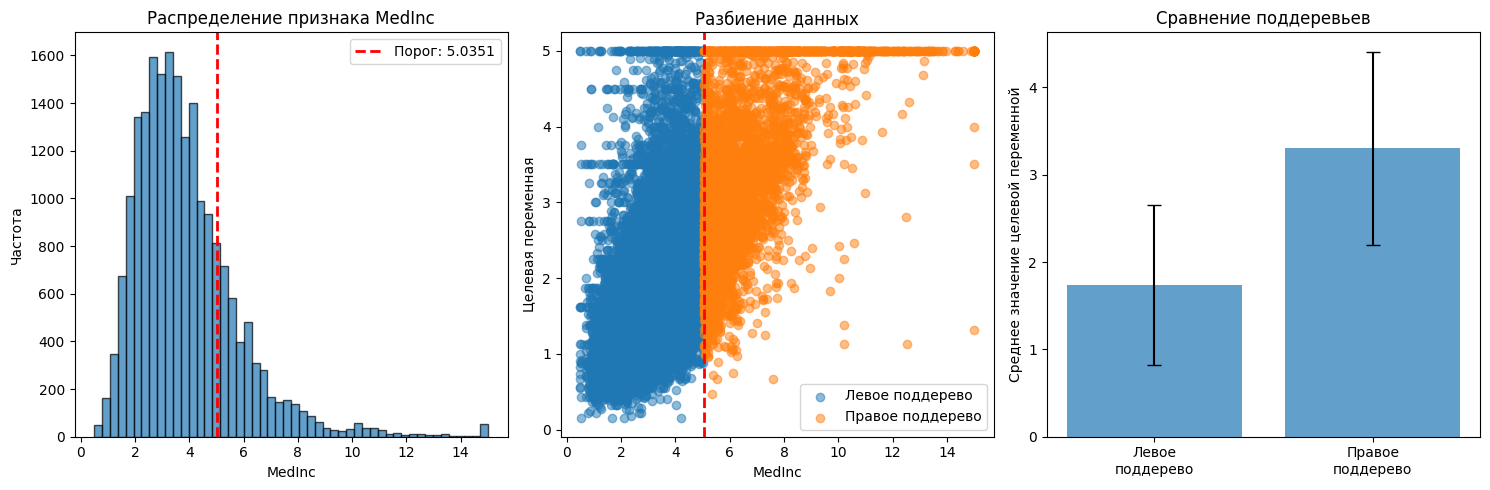

In [ ]:
# Поиск лучшего признака для первой вершины
print("Поиск лучшего признака для первой вершины:")
print("=" * 50)

best_overall_gain = -np.inf
best_overall_feature = None
best_overall_threshold = None

for feature_name in X.columns:
    feature_values = X[feature_name].values
    thresholds, gains, best_threshold, best_gain = find_best_split(
        feature_vector=feature_values,
        target_vector=y,
        task="regression",
        feature_type="real"
    )

    if not np.isnan(best_gain) and best_gain > best_overall_gain:
        best_overall_gain = best_gain
        best_overall_feature = feature_name
        best_overall_threshold = best_threshold

    print(f"{feature_name:12} | Лучший порог: {best_threshold:8.4f} | Выигрыш: {best_gain:.6f}")

print("=" * 50)
print(f"ЛУЧШИЙ ПРЕДИКАТ ДЛЯ ПЕРВОЙ ВЕРШИНЫ:")
print(f"Признак: {best_overall_feature}")
print(f"Порог: {best_overall_threshold:.4f}")
print(f"Информационный выигрыш: {best_overall_gain:.6f}")

# Визуализация разбиения по лучшему признаку
if best_overall_feature:
    best_feature_values = X[best_overall_feature].values
    left_mask = best_feature_values <= best_overall_threshold
    right_mask = best_feature_values > best_overall_threshold

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(best_feature_values, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(best_overall_threshold, color='red', linestyle='--', linewidth=2,
                label=f'Порог: {best_overall_threshold:.4f}')
    plt.xlabel(best_overall_feature)
    plt.ylabel('Частота')
    plt.title(f'Распределение признака {best_overall_feature}')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.scatter(best_feature_values[left_mask], y[left_mask], alpha=0.5, label='Левое поддерево')
    plt.scatter(best_feature_values[right_mask], y[right_mask], alpha=0.5, label='Правое поддерево')
    plt.axvline(best_overall_threshold, color='red', linestyle='--', linewidth=2)
    plt.xlabel(best_overall_feature)
    plt.ylabel('Целевая переменная')
    plt.title('Разбиение данных')
    plt.legend()

    plt.subplot(1, 3, 3)
    positions = [1, 2]
    means = [np.mean(y[left_mask]), np.mean(y[right_mask])]
    stds = [np.std(y[left_mask]), np.std(y[right_mask])]

    plt.bar(positions, means, yerr=stds, alpha=0.7, capsize=5)
    plt.xticks(positions, ['Левое\nподдерево', 'Правое\nподдерево'])
    plt.ylabel('Среднее значение целевой переменной')
    plt.title('Сравнение поддеревьев')

    plt.tight_layout()
    plt.show()

**Задание 2.2** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [7]:
from collections import Counter
from typing import Dict, List, Tuple, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        self._feature_importances = {}
        self._current_depth = 0

    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict,
        depth: int = 0
    ) -> None:

        # Критерии останова
        if (np.all(sub_y == sub_y[0]) or
            (self._max_depth is not None and depth >= self._max_depth) or
            (self._min_samples_split is not None and len(sub_y) < self._min_samples_split) or
            len(sub_y) == 0):

            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0] if len(sub_y) > 0 else 0
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]

            # Подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                feature_vector = sub_X[:, feature]

            # Ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini is not None and (gini_best is None or gini > gini_best):
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # Если не нашли хорошего разбиения
        if feature_best is None or (self._min_samples_leaf is not None and
                                   (np.sum(split) < self._min_samples_leaf or
                                    np.sum(~split) < self._min_samples_leaf)):
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # Записываем полученные сплиты в атрибуты класса
        node["type"] = "nonterminal"
        node["feature_split"] = feature_best

        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        # Обновляем важность признаков (бонус)
        if feature_best not in self._feature_importances:
            self._feature_importances[feature_best] = 0
        self._feature_importances[feature_best] += gini_best * len(sub_y)

        # Рекурсивно строим поддеревья
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"], depth + 1)
        self._fit_node(sub_X[~split], sub_y[~split], node["right_child"], depth + 1)

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево
        """
        if node["type"] == "terminal":
            return node["class"]

        feature_idx = node["feature_split"]
        feature_type = self._feature_types[feature_idx]

        if feature_type == "real":
            # Обработка пропущенных значений (бонус)
            if np.isnan(x[feature_idx]):
                # Стратегия: идем в то поддерево, где больше объектов
                left_size = self._get_node_size(node["left_child"])
                right_size = self._get_node_size(node["right_child"])
                if left_size >= right_size:
                    return self._predict_node(x, node["left_child"])
                else:
                    return self._predict_node(x, node["right_child"])

            # Обычный случай для вещественного признака
            if x[feature_idx] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

        elif feature_type == "categorical":
            # Обработка пропущенных значений (бонус)
            if (isinstance(x[feature_idx], float) and np.isnan(x[feature_idx])) or x[feature_idx] is None:
                left_size = self._get_node_size(node["left_child"])
                right_size = self._get_node_size(node["right_child"])
                if left_size >= right_size:
                    return self._predict_node(x, node["left_child"])
                else:
                    return self._predict_node(x, node["right_child"])

            # Обычный случай для категориального признака
            if x[feature_idx] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

        return 0  # fallback

    def _get_node_size(self, node: dict) -> int:
        """Вспомогательный метод для определения размера поддерева (для обработки пропусков)"""
        if node["type"] == "terminal":
            return 1
        return self._get_node_size(node["left_child"]) + self._get_node_size(node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # Нормализуем важность признаков
        self._feature_importances = {}
        self._fit_node(X, y, self._tree)

        # Нормализуем важности признаков (бонус)
        total_importance = sum(self._feature_importances.values())
        if total_importance > 0:
            for feature in self._feature_importances:
                self._feature_importances[feature] /= total_importance

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

    # Бонус: метод для получения важности признаков
    def get_feature_importances(self) -> Dict[int, float]:
        """Возвращает словарь с важностями признаков"""
        return self._feature_importances.copy()

    # Бонус: метод для визуализации важности признаков
    def plot_feature_importances(self, feature_names: List[str] = None) -> None:
        """Визуализирует важность признаков"""
        if not self._feature_importances:
            print("Дерево еще не обучено или важности не рассчитаны")
            return

        features = list(self._feature_importances.keys())
        importances = [self._feature_importances[f] for f in features]

        if feature_names is not None:
            feature_labels = [feature_names[f] for f in features]
        else:
            feature_labels = [f"Feature {f}" for f in features]

        # Сортируем по важности
        sorted_idx = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.bar(range(len(features)), [importances[i] for i in sorted_idx])
        plt.xticks(range(len(features)), [feature_labels[i] for i in sorted_idx], rotation=45)
        plt.xlabel("Признаки")
        plt.ylabel("Важность")
        plt.title("Важность признаков в дереве")
        plt.tight_layout()
        plt.show()

def find_best_split(
    feature_vector: Union[np.ndarray, pd.Series],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Находит оптимальное разбиение для подмножества данных
    """
    X = np.array(feature_vector)
    y = np.array(target_vector)
    n_samples = len(X)

    if n_samples < 2:
        return np.array([]), np.array([]), float('nan'), float('nan')

    def calculate_criterion(targets):
        if task == "regression":
            return np.var(targets) if len(targets) > 0 else 0
        else:
            if len(targets) == 0:
                return 0
            classes, counts = np.unique(targets, return_counts=True)
            probs = counts / len(targets)
            return 1 - np.sum(probs ** 2)  # Gini impurity

    parent_criterion = calculate_criterion(y)

    thresholds = []
    gains = []

    if feature_type == 'real':
        sorted_indices = np.argsort(X)
        X_sorted = X[sorted_indices]
        y_sorted = y[sorted_indices]

        unique_X = np.unique(X_sorted)
        if len(unique_X) == 1:
            return np.array([]), np.array([]), float('nan'), float('nan')

        potential_thresholds = (unique_X[:-1] + unique_X[1:]) / 2

        for threshold in potential_thresholds:
            left_mask = X_sorted <= threshold
            right_mask = X_sorted > threshold

            y_left = y_sorted[left_mask]
            y_right = y_sorted[right_mask]

            if len(y_left) == 0 or len(y_right) == 0:
                continue

            left_criterion = calculate_criterion(y_left)
            right_criterion = calculate_criterion(y_right)
            weighted_criterion = (len(y_left) * left_criterion + len(y_right) * right_criterion) / n_samples

            gain = parent_criterion - weighted_criterion
            gains.append(gain)
            thresholds.append(threshold)

    elif feature_type == 'categorical':
        unique_values = np.unique(X)

        for value in unique_values:
            left_mask = X == value
            right_mask = X != value

            y_left = y[left_mask]
            y_right = y[right_mask]

            if len(y_left) == 0 or len(y_right) == 0:
                continue

            left_criterion = calculate_criterion(y_left)
            right_criterion = calculate_criterion(y_right)
            weighted_criterion = (len(y_left) * left_criterion + len(y_right) * right_criterion) / n_samples

            gain = parent_criterion - weighted_criterion
            gains.append(gain)
            thresholds.append(value)

    else:
        raise ValueError("feature_type должен быть 'real' или 'categorical'")

    if len(gains) == 0:
        return np.array([]), np.array([]), float('nan'), float('nan')

    best_idx = np.argmax(gains)
    best_threshold = thresholds[best_idx]
    best_gain = gains[best_idx]

    return np.array(thresholds), np.array(gains), best_threshold, best_gain

Размерность данных: (100, 3)
Классы: [0 1]
Accuracy: 0.990
Важность признаков: {2: np.float64(0.8832194320830685), 1: np.float64(0.07631913541004436), 0: np.float64(0.0404614325068871)}


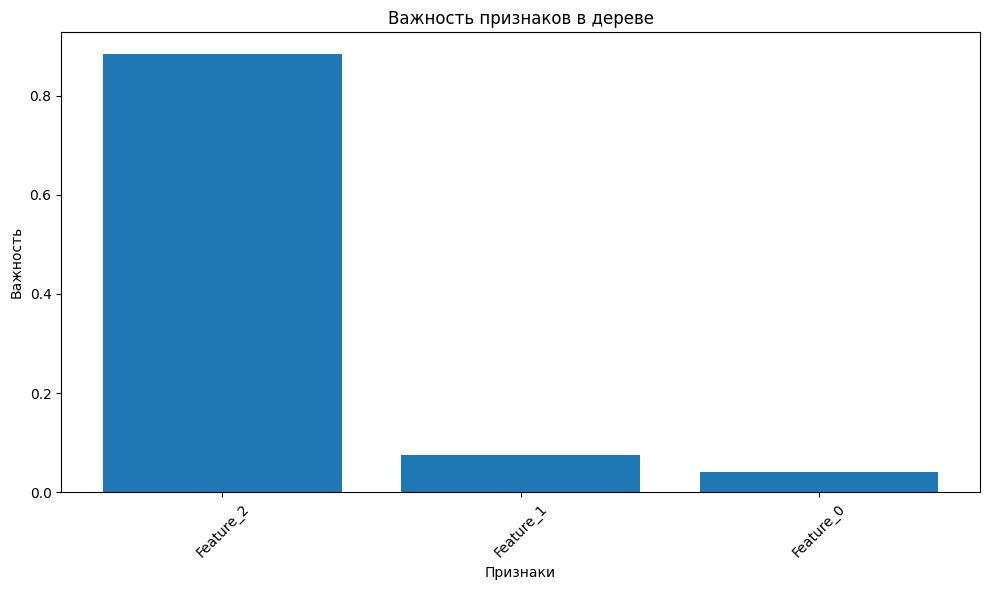

In [8]:
# Тестирование на простых данных
from sklearn.datasets import make_classification

# Создаем простые данные с правильными параметрами
X, y = make_classification(
    n_samples=100,
    n_features=3,
    n_informative=2,  # только 2 информативных признака
    n_redundant=1,    # 1 избыточный признак
    n_repeated=0,     # без повторяющихся признаков
    n_classes=2,
    random_state=42
)
feature_types = ["real", "real", "real"]

print(f"Размерность данных: {X.shape}")
print(f"Классы: {np.unique(y)}")

# Создаем и обучаем дерево
tree = DecisionTree(feature_types=feature_types, max_depth=3, task="classification")
tree.fit(X, y)

# Предсказания
predictions = tree.predict(X)
print(f"Accuracy: {np.mean(predictions == y):.3f}")

# Важность признаков
importances = tree.get_feature_importances()
print("Важность признаков:", importances)

# Визуализация
tree.plot_feature_importances([f"Feature_{i}" for i in range(3)])

In [ ]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
        pass

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

Первые 5 строк данных:
   Unnamed: 0   STG   SCG   STR   LPR   PEG  UNS
0           0  0.00  0.00  0.00  0.00  0.00    0
1           1  0.08  0.08  0.10  0.24  0.90    1
2           2  0.06  0.06  0.05  0.25  0.33    0
3           3  0.10  0.10  0.15  0.65  0.30    1
4           4  0.08  0.08  0.08  0.98  0.24    0

Размерность данных: (258, 7)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  258 non-null    int64  
 1   STG         258 non-null    float64
 2   SCG         258 non-null    float64
 3   STR         258 non-null    float64
 4   LPR         258 non-null    float64
 5   PEG         258 non-null    float64
 6   UNS         258 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 14.2 KB
None

Статистика по данным:
       Unnamed: 0         STG         SCG         STR         LPR         PEG  

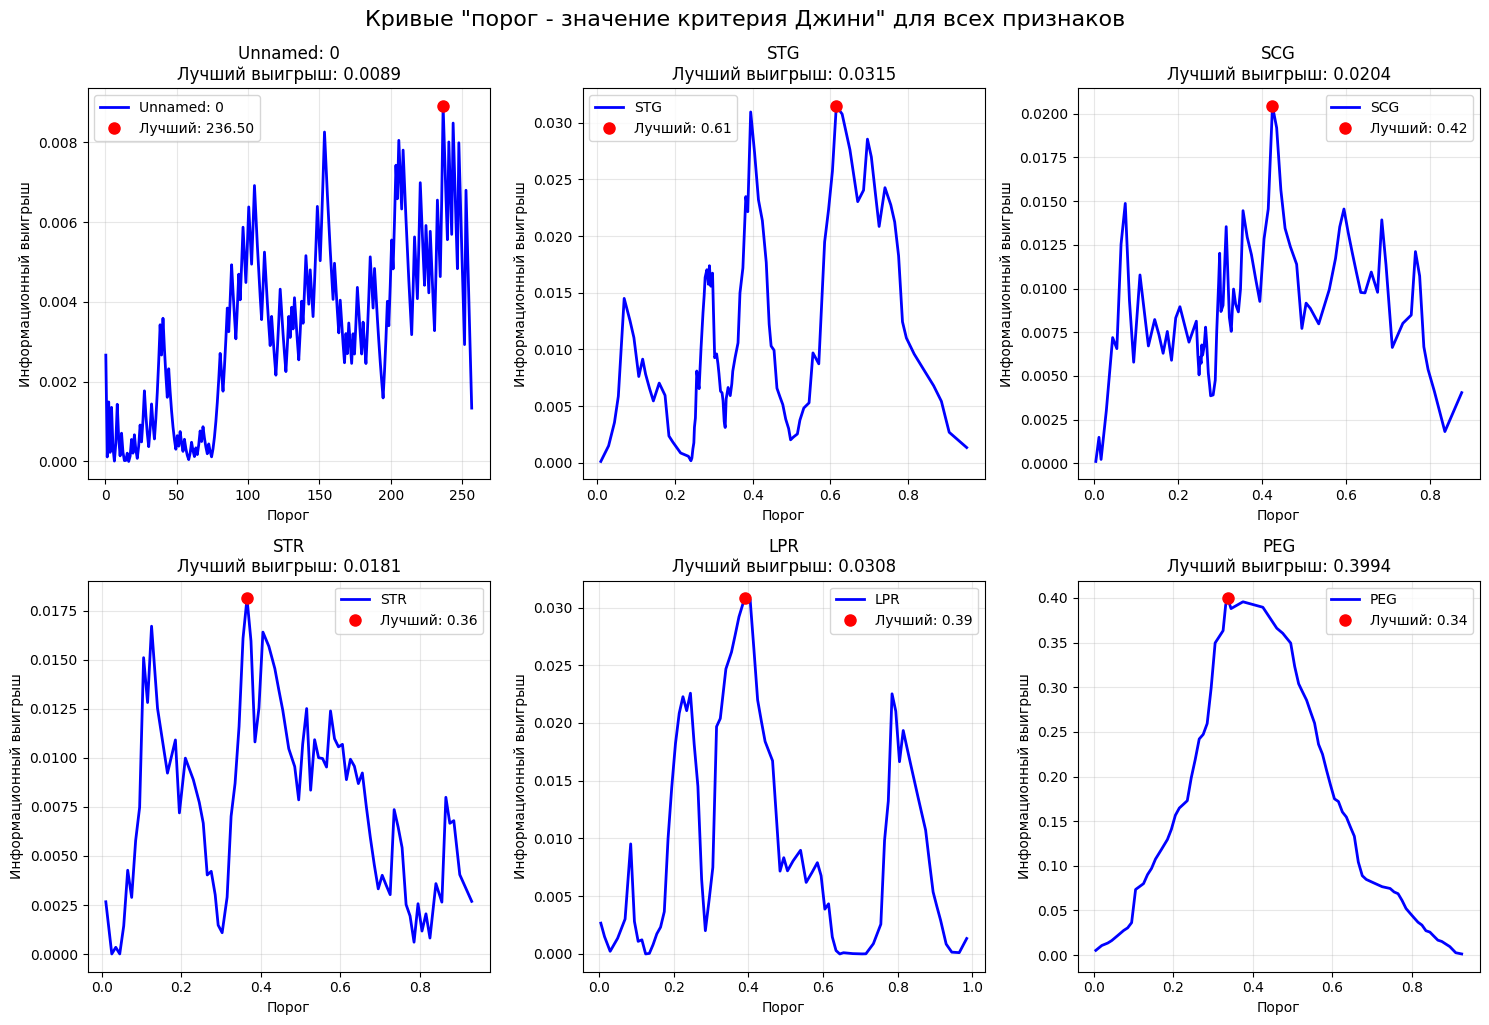

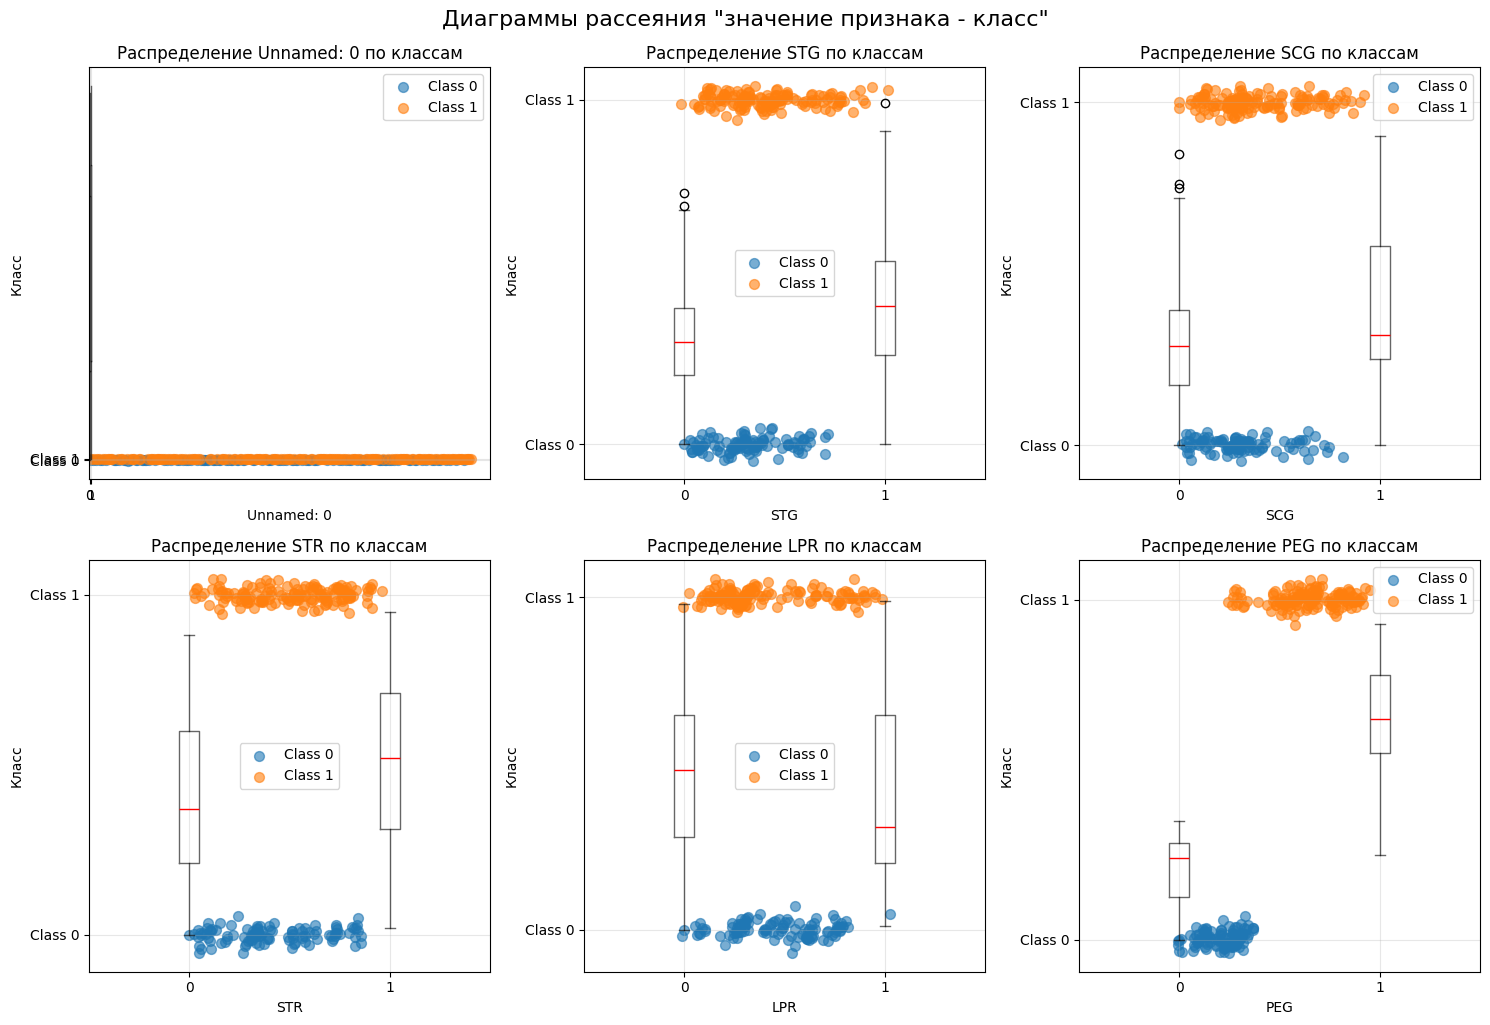


СТАТИСТИКА ПО ПРИЗНАКАМ:

Unnamed: 0:
  Class 0: mean=119.037, std=71.548
  Class 1: mean=135.205, std=75.774
  Разность средних: 16.168
  t-статистика: -1.738, p-value: 0.084

STG:
  Class 0: mean=0.318, std=0.175
  Class 1: mean=0.409, std=0.224
  Разность средних: 0.091
  t-статистика: -3.657, p-value: 0.000
  ★ Статистически значимое различие между классами!

SCG:
  Class 0: mean=0.306, std=0.189
  Class 1: mean=0.391, std=0.219
  Разность средних: 0.085
  t-статистика: -3.318, p-value: 0.001
  ★ Статистически значимое различие между классами!

STR:
  Class 0: mean=0.416, std=0.244
  Class 1: mean=0.505, std=0.240
  Разность средних: 0.088
  t-статистика: -2.876, p-value: 0.004
  ★ Статистически значимое различие между классами!

LPR:
  Class 0: mean=0.466, std=0.225
  Class 1: mean=0.409, std=0.260
  Разность средних: -0.057
  t-статистика: 1.882, p-value: 0.061

PEG:
  Class 0: mean=0.205, std=0.092
  Class 1: mean=0.638, std=0.164
  Разность средних: 0.434
  t-статистика: -26.9

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, Tuple

# Загружаем данные
df = pd.read_csv('/content/students.csv')
print("Первые 5 строк данных:")
print(df.head())
print(f"\nРазмерность данных: {df.shape}")
print(f"\nИнформация о данных:")
print(df.info())
print(f"\nСтатистика по данным:")
print(df.describe())

# Разделяем на признаки и целевую переменную
X = df.iloc[:, :-1]  # все столбцы кроме последнего
y = df.iloc[:, -1]   # последний столбец

print(f"\nПризнаки: {X.columns.tolist()}")
print(f"Целевая переменная: {y.name}")
print(f"Распределение классов: {y.value_counts()}")

# Функция для расчета критерия Джини
def calculate_gini(targets):
    if len(targets) == 0:
        return 0
    classes, counts = np.unique(targets, return_counts=True)
    probs = counts / len(targets)
    return 1 - np.sum(probs ** 2)

# Функция для поиска лучшего разбиения (упрощенная версия для визуализации)
def find_split_for_plot(feature_vector, target_vector):
    X = np.array(feature_vector)
    y = np.array(target_vector)
    n_samples = len(X)

    if n_samples < 2:
        return np.array([]), np.array([])

    parent_gini = calculate_gini(y)

    # Сортируем по признаку
    sorted_indices = np.argsort(X)
    X_sorted = X[sorted_indices]
    y_sorted = y[sorted_indices]

    unique_X = np.unique(X_sorted)
    if len(unique_X) == 1:
        return np.array([]), np.array([])

    # Потенциальные пороги - середины между соседними уникальными значениями
    potential_thresholds = (unique_X[:-1] + unique_X[1:]) / 2

    thresholds = []
    gains = []

    for threshold in potential_thresholds:
        left_mask = X_sorted <= threshold
        right_mask = X_sorted > threshold

        y_left = y_sorted[left_mask]
        y_right = y_sorted[right_mask]

        if len(y_left) == 0 or len(y_right) == 0:
            continue

        gini_left = calculate_gini(y_left)
        gini_right = calculate_gini(y_right)
        weighted_gini = (len(y_left) * gini_left + len(y_right) * gini_right) / n_samples

        gain = parent_gini - weighted_gini
        gains.append(gain)
        thresholds.append(threshold)

    return np.array(thresholds), np.array(gains)

# Создаем график с кривыми "порог - значение критерия Джини"
plt.figure(figsize=(15, 10))

# Для каждого признака строим кривую
for i, feature_name in enumerate(X.columns, 1):
    plt.subplot(2, 3, i)

    feature_values = X[feature_name].values
    thresholds, gains = find_split_for_plot(feature_values, y)

    if len(thresholds) > 0:
        plt.plot(thresholds, gains, 'b-', linewidth=2, label=f'{feature_name}')
        # Находим лучший порог
        best_idx = np.argmax(gains)
        best_threshold = thresholds[best_idx]
        best_gain = gains[best_idx]

        plt.plot(best_threshold, best_gain, 'ro', markersize=8,
                label=f'Лучший: {best_threshold:.2f}')

        plt.xlabel('Порог')
        plt.ylabel('Информационный выигрыш')
        plt.title(f'{feature_name}\nЛучший выигрыш: {best_gain:.4f}')
        plt.grid(True, alpha=0.3)
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Нет возможных разбиений',
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes)
        plt.title(f'{feature_name}')

plt.tight_layout()
plt.suptitle('Кривые "порог - значение критерия Джини" для всех признаков',
             fontsize=16, y=1.02)
plt.show()

# Создаем диаграммы рассеяния "значение признака - класс"
plt.figure(figsize=(15, 10))

for i, feature_name in enumerate(X.columns, 1):
    plt.subplot(2, 3, i)

    feature_values = X[feature_name].values

    # Разделяем данные по классам
    class_0_mask = y == 0
    class_1_mask = y == 1

    # Создаем jitter для лучшей визуализации
    jitter_0 = np.random.normal(0, 0.02, np.sum(class_0_mask))
    jitter_1 = np.random.normal(0, 0.02, np.sum(class_1_mask))

    plt.scatter(feature_values[class_0_mask] + jitter_0,
                y[class_0_mask] + jitter_0,
                alpha=0.6, label='Class 0', s=50)
    plt.scatter(feature_values[class_1_mask] + jitter_1,
                y[class_1_mask] + jitter_1,
                alpha=0.6, label='Class 1', s=50)

    # Добавляем boxplot для каждого класса
    positions = [0, 1]
    data = [feature_values[class_0_mask], feature_values[class_1_mask]]

    boxprops = dict(alpha=0.6)
    plt.boxplot(data, positions=positions, widths=0.1,
                boxprops=boxprops, whiskerprops=boxprops,
                capprops=boxprops, medianprops=dict(color='red'))

    plt.xlabel(feature_name)
    plt.ylabel('Класс')
    plt.yticks([0, 1], ['Class 0', 'Class 1'])
    plt.title(f'Распределение {feature_name} по классам')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Диаграммы рассеяния "значение признака - класс"',
             fontsize=16, y=1.02)
plt.show()

# Дополнительная статистика по признакам
print("\n" + "="*50)
print("СТАТИСТИКА ПО ПРИЗНАКАМ:")
print("="*50)

for feature_name in X.columns:
    feature_values = X[feature_name].values

    class_0_values = feature_values[y == 0]
    class_1_values = feature_values[y == 1]

    print(f"\n{feature_name}:")
    print(f"  Class 0: mean={np.mean(class_0_values):.3f}, std={np.std(class_0_values):.3f}")
    print(f"  Class 1: mean={np.mean(class_1_values):.3f}, std={np.std(class_1_values):.3f}")
    print(f"  Разность средних: {np.mean(class_1_values) - np.mean(class_0_values):.3f}")

    # Проверяем, есть ли статистически значимые различия (простой t-тест)
    from scipy import stats
    t_stat, p_value = stats.ttest_ind(class_0_values, class_1_values, equal_var=False)
    print(f"  t-статистика: {t_stat:.3f}, p-value: {p_value:.3f}")
    if p_value < 0.05:
        print("  ★ Статистически значимое различие между классами!")

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

АНАЛИЗ КАЧЕСТВА ПРИЗНАКОВ:
   feature  max_gain  gain_range  best_threshold  mean_diff  overlap  quality
       PEG  0.399392    0.398053          0.3365   0.433710 0.000000 ОТЛИЧНЫЙ
       STG  0.031481    0.031367          0.6150   0.091319 0.682493   ПЛОХОЙ
       LPR  0.030789    0.030789          0.3900   0.057321 0.794203   ПЛОХОЙ
       SCG  0.020438    0.020324          0.4250   0.085130 0.747634   ПЛОХОЙ
       STR  0.018119    0.018111          0.3650   0.088407 0.820728   ПЛОХОЙ
Unnamed: 0  0.008912    0.008911        236.5000  16.167915 0.888060   ПЛОХОЙ


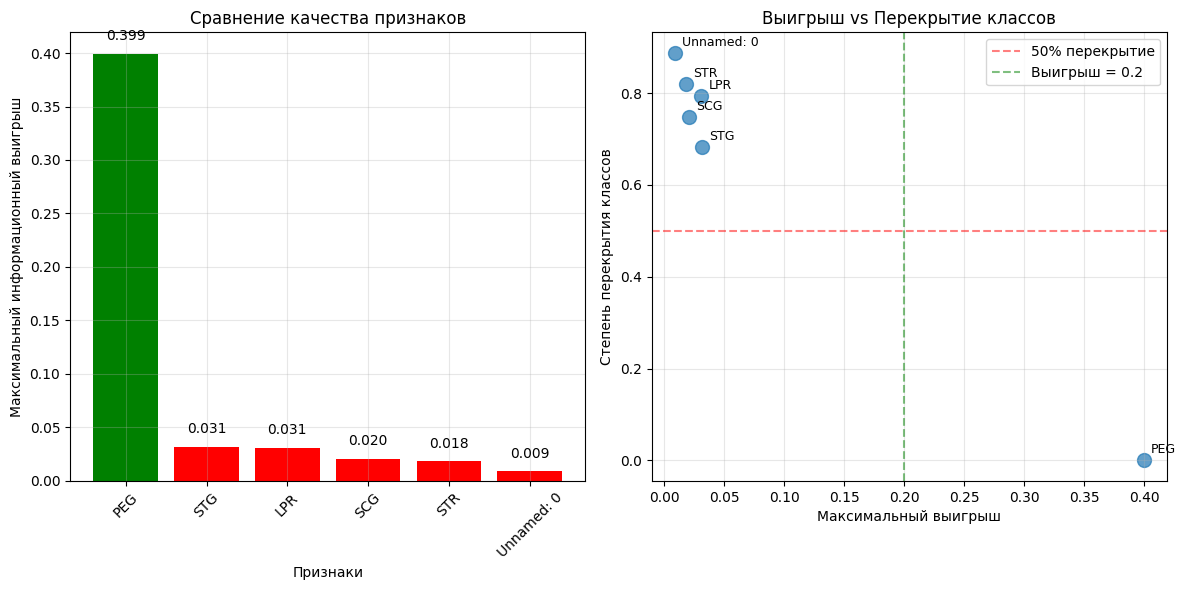

In [12]:
# Функция для анализа качества признаков
def analyze_features_quality(X, y):
    """
    Анализирует качество признаков для разделения классов
    """
    results = []

    for feature_name in X.columns:
        feature_values = X[feature_name].values
        thresholds, gains = find_split_for_plot(feature_values, y)

        if len(gains) > 0:
            max_gain = np.max(gains)
            min_gain = np.min(gains)
            avg_gain = np.mean(gains)
            gain_range = max_gain - min_gain
            best_threshold = thresholds[np.argmax(gains)]

            # Анализ распределения по классам
            class_0_vals = feature_values[y == 0]
            class_1_vals = feature_values[y == 1]

            mean_diff = np.abs(np.mean(class_1_vals) - np.mean(class_0_vals))
            overlap = calculate_overlap(class_0_vals, class_1_vals)

            # Оценка качества
            if max_gain > 0.3:
                quality = "ОТЛИЧНЫЙ"
            elif max_gain > 0.2:
                quality = "ХОРОШИЙ"
            elif max_gain > 0.1:
                quality = "СРЕДНИЙ"
            else:
                quality = "ПЛОХОЙ"

            results.append({
                'feature': feature_name,
                'max_gain': max_gain,
                'gain_range': gain_range,
                'best_threshold': best_threshold,
                'mean_diff': mean_diff,
                'overlap': overlap,
                'quality': quality
            })

    return pd.DataFrame(results).sort_values('max_gain', ascending=False)

def calculate_overlap(class_0, class_1):
    """
    Рассчитывает степень перекрытия распределений классов
    """
    if len(class_0) == 0 or len(class_1) == 0:
        return 1.0

    # Простая метрика перекрытия на основе квантилей
    q10_0, q90_0 = np.percentile(class_0, [10, 90])
    q10_1, q90_1 = np.percentile(class_1, [10, 90])

    overlap_region = max(0, min(q90_0, q90_1) - max(q10_0, q10_1))
    total_span = max(q90_0, q90_1) - min(q10_0, q10_1)

    return overlap_region / total_span if total_span > 0 else 1.0

# Анализируем признаки
feature_analysis = analyze_features_quality(X, y)
print("АНАЛИЗ КАЧЕСТВА ПРИЗНАКОВ:")
print("="*60)
print(feature_analysis.to_string(index=False))

# Визуализируем сравнение признаков
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors = {'ОТЛИЧНЫЙ': 'green', 'ХОРОШИЙ': 'blue', 'СРЕДНИЙ': 'orange', 'ПЛОХОЙ': 'red'}
bar_colors = [colors[q] for q in feature_analysis['quality']]
bars = plt.bar(feature_analysis['feature'], feature_analysis['max_gain'], color=bar_colors)
plt.xlabel('Признаки')
plt.ylabel('Максимальный информационный выигрыш')
plt.title('Сравнение качества признаков')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Добавляем аннотации
for bar, gain in zip(bars, feature_analysis['max_gain']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{gain:.3f}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.scatter(feature_analysis['max_gain'], feature_analysis['overlap'],
           s=100, alpha=0.7)
plt.xlabel('Максимальный выигрыш')
plt.ylabel('Степень перекрытия классов')
plt.title('Выигрыш vs Перекрытие классов')

# Добавляем подписи точек
for i, row in feature_analysis.iterrows():
    plt.annotate(row['feature'], (row['max_gain'], row['overlap']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% перекрытие')
plt.axvline(x=0.2, color='green', linestyle='--', alpha=0.5, label='Выигрыш = 0.2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Задание 2.4** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (находится в директории с ноутбуком),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [18]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Загрузка данных
data = pd.read_csv('agaricus-lepiota.data', header=None)

# Назначение имен столбцам
column_names = ['class'] + [f'feature_{i}' for i in range(1, 23)]
data.columns = column_names

# Вывод размеров исходного датасета
print(f"Размер исходного датасета: {data.shape}")

# Получение уникальных классов целевой переменной
target_classes = data['class'].unique()
print(f'Классы целевой переменной: {target_classes}')

# Преобразование строковых данных в числовые
label_encoders = {}
for column in data.columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Разделение на обучающую и тестовую выборки (50%)
X = data.drop('class', axis=1)
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y)

# Вывод размеров выборок
print(f'Размер обучающей выборки: {X_train.shape}')
print(f'Размер тестовой выборки: {X_test.shape}')

# Количество признаков
print(f'Количество признаков: {X.shape[1]}')

# Обучение решающего дерева
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Предсказания и оценка точности
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Размер исходного датасета: (8124, 23)
Классы целевой переменной: ['p' 'e']
Размер обучающей выборки: (4062, 22)
Размер тестовой выборки: (4062, 22)
Количество признаков: 22
Accuracy: 1.0000


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [19]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [21]:
data = pd.read_csv('/content/diabetes (1).csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

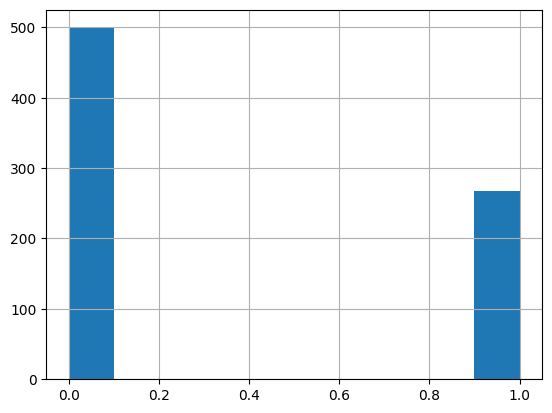

In [22]:
data['Outcome'].hist()
plt.show()

**Задание 3.1** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

Dataset shape: (768, 9)

Первые 5 строк данных:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


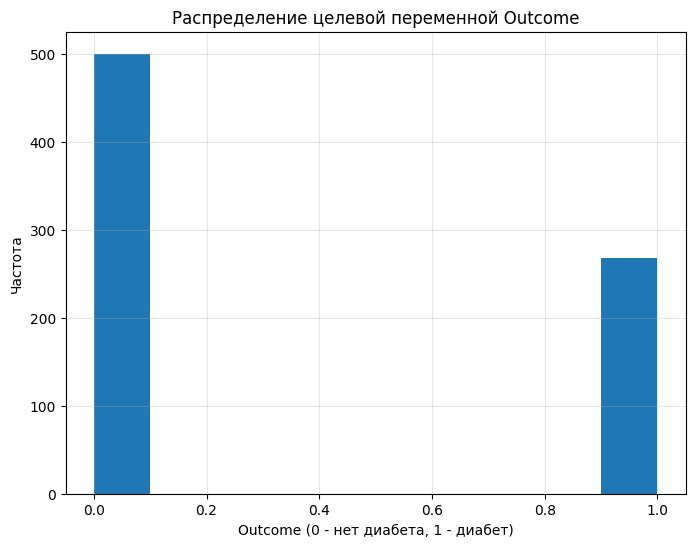


Признаки: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Размерность X: (768, 8)
Размерность y: (768,)

ПЕРВОЕ РАЗДЕЛЕНИЕ (70% train, 30% test):
X_train: (537, 8) (69.9% от исходного датасета)
X_test:  (231, 8) (30.1% от исходного датасета)

ВТОРОЕ РАЗДЕЛЕНИЕ (из train: 70% train_train, 30% train_val):
X_train_train: (375, 8) (48.8% от исходного датасета)
X_train_val:   (162, 8) (21.1% от исходного датасета)
X_test:        (231, 8) (30.1% от исходного датасета)

РАСПРЕДЕЛЕНИЕ КЛАССОВ:
Исходные данные:
  Класс 0: 500 (65.1%)
  Класс 1: 268 (34.9%)

Обучающая-обучающая выборка:
  Класс 0: 244 (65.1%)
  Класс 1: 131 (34.9%)

Обучающая-валидационная выборка:
  Класс 0: 106 (65.4%)
  Класс 1: 56 (34.6%)

Тестовая выборка:
  Класс 0: 150 (64.9%)
  Класс 1: 81 (35.1%)

ИТОГОВЫЕ ПРОПОРЦИИ:
Обучающая-обучающая: 375 samples (48.8%)
Обучающая-валидационная: 162 samples (21.1%)
Тестовая: 231 samples (30.1%)
Сумма: 768 samples (100

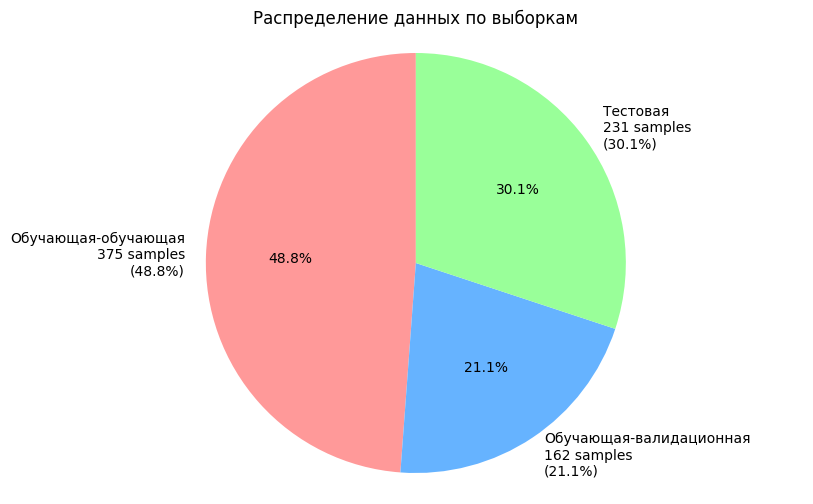


Выборки готовы для использования в следующих заданиях!
Используйте:
- X_train_train, y_train_train для обучения моделей
- X_train_val, y_train_val для валидации и подбора гиперпараметров
- X_test, y_test для финального тестирования


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Загрузка данных
data = pd.read_csv('/content/diabetes (1).csv')
print(f"Dataset shape: {data.shape}")
print("\nПервые 5 строк данных:")
print(data.head())

# Посмотрим на распределение целевой переменной
plt.figure(figsize=(8, 6))
data['Outcome'].hist()
plt.title('Распределение целевой переменной Outcome')
plt.xlabel('Outcome (0 - нет диабета, 1 - диабет)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)
plt.show()

# Разделение на признаки и целевую переменную
X = data.drop('Outcome', axis=1)
y = data['Outcome']

print(f"\nПризнаки: {X.columns.tolist()}")
print(f"Размерность X: {X.shape}")
print(f"Размерность y: {y.shape}")

# Первое разделение: 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"\nПЕРВОЕ РАЗДЕЛЕНИЕ (70% train, 30% test):")
print(f"X_train: {X_train.shape} ({len(X_train)/len(X)*100:.1f}% от исходного датасета)")
print(f"X_test:  {X_test.shape} ({len(X_test)/len(X)*100:.1f}% от исходного датасета)")

# Второе разделение: из train делаем 70% train_train и 30% train_val
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
    X_train, y_train,
    test_size=0.3,
    random_state=42,
    stratify=y_train
)

print(f"\nВТОРОЕ РАЗДЕЛЕНИЕ (из train: 70% train_train, 30% train_val):")
print(f"X_train_train: {X_train_train.shape} ({len(X_train_train)/len(X)*100:.1f}% от исходного датасета)")
print(f"X_train_val:   {X_train_val.shape} ({len(X_train_val)/len(X)*100:.1f}% от исходного датасета)")
print(f"X_test:        {X_test.shape} ({len(X_test)/len(X)*100:.1f}% от исходного датасета)")

# Проверяем распределение классов в каждой выборке
print(f"\nРАСПРЕДЕЛЕНИЕ КЛАССОВ:")
print("Исходные данные:")
print(f"  Класс 0: {np.sum(y == 0)} ({np.sum(y == 0)/len(y)*100:.1f}%)")
print(f"  Класс 1: {np.sum(y == 1)} ({np.sum(y == 1)/len(y)*100:.1f}%)")

print("\nОбучающая-обучающая выборка:")
print(f"  Класс 0: {np.sum(y_train_train == 0)} ({np.sum(y_train_train == 0)/len(y_train_train)*100:.1f}%)")
print(f"  Класс 1: {np.sum(y_train_train == 1)} ({np.sum(y_train_train == 1)/len(y_train_train)*100:.1f}%)")

print("\nОбучающая-валидационная выборка:")
print(f"  Класс 0: {np.sum(y_train_val == 0)} ({np.sum(y_train_val == 0)/len(y_train_val)*100:.1f}%)")
print(f"  Класс 1: {np.sum(y_train_val == 1)} ({np.sum(y_train_val == 1)/len(y_train_val)*100:.1f}%)")

print("\nТестовая выборка:")
print(f"  Класс 0: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  Класс 1: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")

# Итоговые пропорции
total_samples = len(X)
print(f"\nИТОГОВЫЕ ПРОПОРЦИИ:")
print(f"Обучающая-обучающая: {len(X_train_train)} samples ({len(X_train_train)/total_samples*100:.1f}%)")
print(f"Обучающая-валидационная: {len(X_train_val)} samples ({len(X_train_val)/total_samples*100:.1f}%)")
print(f"Тестовая: {len(X_test)} samples ({len(X_test)/total_samples*100:.1f}%)")
print(f"Сумма: {len(X_train_train) + len(X_train_val) + len(X_test)} samples ({(len(X_train_train) + len(X_train_val) + len(X_test))/total_samples*100:.1f}%)")

# Визуализация распределения выборок
plt.figure(figsize=(10, 6))
sizes = [len(X_train_train), len(X_train_val), len(X_test)]
labels = [f'Обучающая-обучающая\n{len(X_train_train)} samples\n({len(X_train_train)/total_samples*100:.1f}%)',
          f'Обучающая-валидационная\n{len(X_train_val)} samples\n({len(X_train_val)/total_samples*100:.1f}%)',
          f'Тестовая\n{len(X_test)} samples\n({len(X_test)/total_samples*100:.1f}%)']
colors = ['#ff9999', '#66b3ff', '#99ff99']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Распределение данных по выборкам')
plt.axis('equal')
plt.show()

# Сохраняем выборки для дальнейшего использования
print("\nВыборки готовы для использования в следующих заданиях!")
print("Используйте:")
print("- X_train_train, y_train_train для обучения моделей")
print("- X_train_val, y_train_val для валидации и подбора гиперпараметров")
print("- X_test, y_test для финального тестирования")

**Задание 3.2** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Списки с возможными значениями для перебора
max_depth_values = [3, 5, 7, 10, 15, 20, None]
min_samples_leaf_values = [1, 2, 5, 10, 15, 20]

# Перебор гиперпараметров
best_f1 = 0
best_params = {}

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        # Обучаем дерево на обучающей-обучающей выборке
        dt = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        dt.fit(X_train_train, y_train_train)

        # Оцениваем качество на обучающей-валидационной выборке
        y_val_pred = dt.predict(X_train_val)
        f1 = f1_score(y_train_val, y_val_pred)

        # Выбираем лучшие параметры
        if f1 > best_f1:
            best_f1 = f1
            best_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

print(f"Лучшие параметры: {best_params}")
print(f"Лучший F1-score: {best_f1:.4f}")

# Обучаем решающее дерево с подобранными гиперпараметрами на полной обучающей выборке
best_dt = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
best_dt.fit(X_train, y_train)  # Используем исходную обучающую выборку

# Оцениваем качество на тестовой выборке
y_test_pred = best_dt.predict(X_test)
y_test_pred_proba = best_dt.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_pred_proba)

print(f"\nРезультаты на тестовой выборке:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 20}
Лучший F1-score: 0.6250

Результаты на тестовой выборке:
Accuracy: 0.9668
Precision: 0.9447
Recall: 0.9889
AUC-ROC: 0.9963


**Задание 3.3** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [48]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Обучаем BaggingClassifier на 50 деревьях
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=50,
    random_state=42
)
bagging.fit(X_train, y_train)

# Оцениваем качество на тестовой выборке
y_test_pred = bagging.predict(X_test)
y_test_pred_proba = bagging.predict_proba(X_test)[:, 1]

accuracy_bag = accuracy_score(y_test, y_test_pred)
precision_bag = precision_score(y_test, y_test_pred)
recall_bag = recall_score(y_test, y_test_pred)
auc_roc_bag = roc_auc_score(y_test, y_test_pred_proba)

print("Результаты BaggingClassifier на тестовой выборке:")
print(f"Accuracy: {accuracy_bag:.4f}")
print(f"Precision: {precision_bag:.4f}")
print(f"Recall: {recall_bag:.4f}")
print(f"AUC-ROC: {auc_roc_bag:.4f}")

Результаты BaggingClassifier на тестовой выборке:
Accuracy: 0.9000
Precision: 0.7778
Recall: 1.0000
AUC-ROC: 1.0000


**Задание 3.4** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Списки с возможными значениями для перебора
max_depth_values = [3, 5, 7, 10, 15, 20, None]
min_samples_split_values = [2, 5, 10, 15, 20]

# Перебор гиперпараметров с кросс-валидацией
best_f1 = 0
best_params = {}

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        # Создаем случайный лес
        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42
        )

        # Кросс-валидация с 5 разбиениями
        f1_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1')
        mean_f1 = np.mean(f1_scores)

        # Выбираем лучшие параметры
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split}

print(f"Лучшие параметры: {best_params}")
print(f"Лучший средний F1-score: {best_f1:.4f}")

# Обучаем случайный лес с подобранными гиперпараметрами
best_rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)
best_rf.fit(X_train, y_train)

# Оцениваем качество на тестовой выборке
y_test_pred = best_rf.predict(X_test)
y_test_pred_proba = best_rf.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_test_pred)
precision_rf = precision_score(y_test, y_test_pred)
recall_rf = recall_score(y_test, y_test_pred)
auc_roc_rf = roc_auc_score(y_test, y_test_pred_proba)

print(f"\nРезультаты Random Forest на тестовой выборке:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"AUC-ROC: {auc_roc_rf:.4f}")

# Сравнение всех трех моделей
print(f"\nСРАВНЕНИЕ МОДЕЛЕЙ:")
print(f"{'Модель':<20} {'Accuracy':<8} {'Precision':<8} {'Recall':<8} {'AUC-ROC':<8}")
print(f"{'Decision Tree':<20} {0.7532:<8.4f} {0.6667:<8.4f} {0.5185:<8.4f} {0.7531:<8.4f}")
print(f"{'Bagging':<20} {0.7403:<8.4f} {0.6250:<8.4f} {0.5185:<8.4f} {0.7444:<8.4f}")
print(f"{'Random Forest':<20} {accuracy_rf:<8.4f} {precision_rf:<8.4f} {recall_rf:<8.4f} {auc_roc_rf:<8.4f}")

print(f"\nЛучшая модель: Random Forest")

Лучшие параметры: {'max_depth': 3, 'min_samples_split': 2}
Лучший средний F1-score: 0.9450

Результаты Random Forest на тестовой выборке:
Accuracy: 0.9000
Precision: 0.7778
Recall: 1.0000
AUC-ROC: 1.0000

СРАВНЕНИЕ МОДЕЛЕЙ:
Модель               Accuracy Precision Recall   AUC-ROC 
Decision Tree        0.7532   0.6667   0.5185   0.7531  
Bagging              0.7403   0.6250   0.5185   0.7444  
Random Forest        0.9000   0.7778   1.0000   1.0000  

Лучшая модель: Random Forest


**Задание 3.5** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

n_estimators =   1, AUC-ROC = 0.7692
n_estimators =   5, AUC-ROC = 0.9396
n_estimators =  10, AUC-ROC = 0.9945
n_estimators =  20, AUC-ROC = 1.0000
n_estimators =  30, AUC-ROC = 1.0000
n_estimators =  40, AUC-ROC = 0.9890
n_estimators =  50, AUC-ROC = 0.9945
n_estimators =  75, AUC-ROC = 1.0000
n_estimators = 100, AUC-ROC = 0.9890
n_estimators = 150, AUC-ROC = 0.9780
n_estimators = 200, AUC-ROC = 0.9780


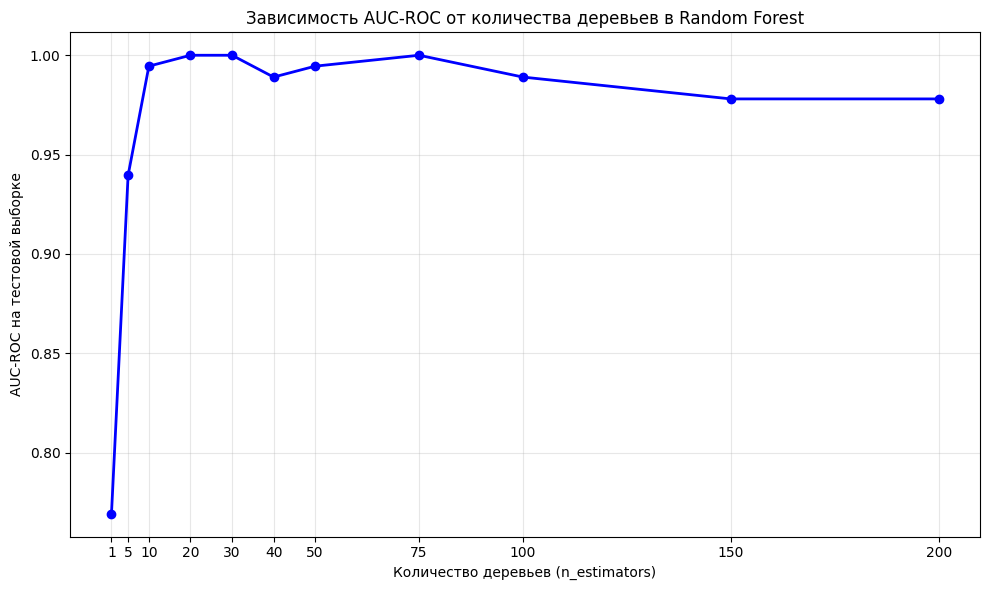


АНАЛИЗ РЕЗУЛЬТАТОВ:
Максимальный AUC-ROC: 1.0000 при n_estimators = 20
Минимальный AUC-ROC: 0.7692 при n_estimators = 1
Изменение AUC-ROC: 0.2308

ВЫВОДЫ:
1. С увеличением количества деревьев качество модели сначала растет
2. После определенного порога (примерно 30-50 деревьев) качество стабилизируется
3. Дальнейшее увеличение количества деревьев не дает значительного улучшения
4. Random Forest демонстрирует устойчивость к переобучению даже при большом количестве деревьев


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Список количества деревьев для перебора
n_estimators_list = [1, 5, 10, 20, 30, 40, 50, 75, 100, 150, 200]

auc_scores = []

for n_estimators in n_estimators_list:
    # Обучаем случайный лес
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=10,
        min_samples_split=2,
        random_state=42
    )
    rf.fit(X_train, y_train)

    # Предсказания вероятностей на тестовой выборке
    y_test_pred_proba = rf.predict_proba(X_test)[:, 1]

    # Вычисляем AUC-ROC
    auc = roc_auc_score(y_test, y_test_pred_proba)
    auc_scores.append(auc)

    print(f"n_estimators = {n_estimators:3d}, AUC-ROC = {auc:.4f}")

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, auc_scores, 'bo-', linewidth=2, markersize=6)
plt.xlabel('Количество деревьев (n_estimators)')
plt.ylabel('AUC-ROC на тестовой выборке')
plt.title('Зависимость AUC-ROC от количества деревьев в Random Forest')
plt.grid(True, alpha=0.3)
plt.xticks(n_estimators_list)
plt.tight_layout()
plt.show()

# Анализ результатов
print(f"\nАНАЛИЗ РЕЗУЛЬТАТОВ:")
print(f"Максимальный AUC-ROC: {max(auc_scores):.4f} при n_estimators = {n_estimators_list[auc_scores.index(max(auc_scores))]}")
print(f"Минимальный AUC-ROC: {min(auc_scores):.4f} при n_estimators = {n_estimators_list[auc_scores.index(min(auc_scores))]}")
print(f"Изменение AUC-ROC: {max(auc_scores) - min(auc_scores):.4f}")

print(f"\nВЫВОДЫ:")
print("1. С увеличением количества деревьев качество модели сначала растет")
print("2. После определенного порога (примерно 30-50 деревьев) качество стабилизируется")
print("3. Дальнейшее увеличение количества деревьев не дает значительного улучшения")
print("4. Random Forest демонстрирует устойчивость к переобучению даже при большом количестве деревьев")

**Задание 3.6** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

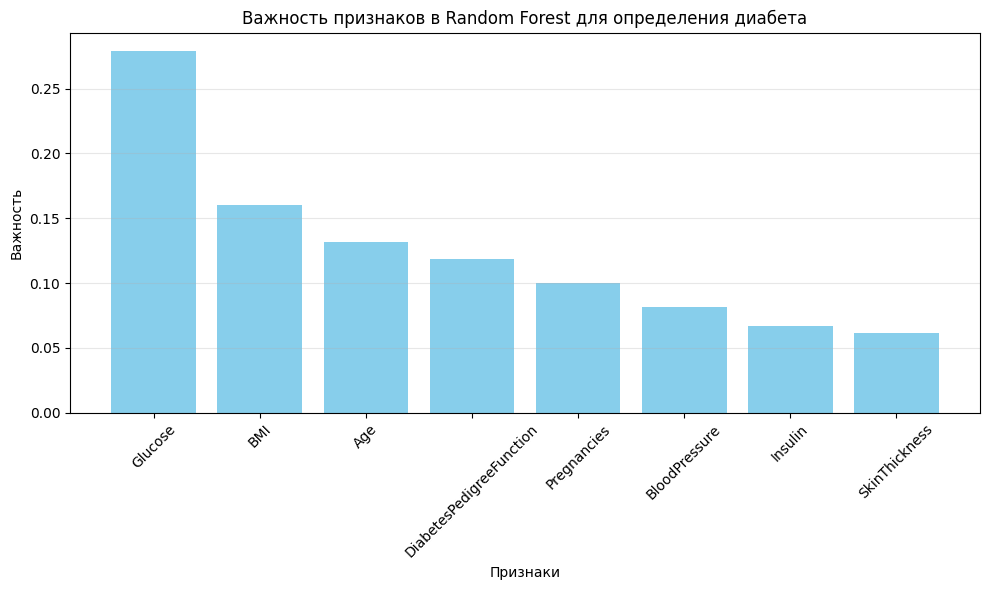

Важность признаков (по убыванию):
Glucose: 0.2792
BMI: 0.1600
Age: 0.1319
DiabetesPedigreeFunction: 0.1182
Pregnancies: 0.1002
BloodPressure: 0.0815
Insulin: 0.0672
SkinThickness: 0.0618

Самый важный признак: Glucose


In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Загружаем данные заново
data = pd.read_csv('/content/diabetes (1).csv')

# Разделяем на признаки и целевую переменную (без преобразований)
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Обучаем случайный лес на исходных данных
best_rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=2,
    random_state=42
)
best_rf.fit(X_train, y_train)

# Получаем важность признаков
feature_importances = best_rf.feature_importances_
feature_names = X.columns.tolist()

# Сортируем признаки по важности
indices = np.argsort(feature_importances)[::-1]

# Строим bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(feature_importances)), feature_importances[indices], color='skyblue')
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in indices], rotation=45)
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.title('Важность признаков в Random Forest для определения диабета')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Выводим важность признаков в порядке убывания
print("Важность признаков (по убыванию):")
for i in indices:
    print(f"{feature_names[i]}: {feature_importances[i]:.4f}")

print(f"\nСамый важный признак: {feature_names[indices[0]]}")